In [17]:
%load_ext autoreload
%autoreload 2

import optax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from pendulum_utils import get_coordinates, get_rk_state_sequence
from pendulum_training import fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

mu0 = jnp.array([jnp.pi / 4, jnp.pi / 3, 0., 0.])
V0 = jnp.eye(4) * 0.0001

delta_t = 0.01
trans_noise = jnp.eye(4) * 0.001
obs_noise = jnp.eye(4) * 0.1

### Generate data points

In [8]:
num_steps = 10000
N = 1

states, observations, _ = get_rk_state_sequence(
    delta_t, mu0, V0, trans_noise, obs_noise, num_steps, N, limit_range=False
)
sin_states = jnp.sin(states)
cos_states = jnp.cos(states)

xs, ys = get_coordinates(states)

#### Angles as a function of time

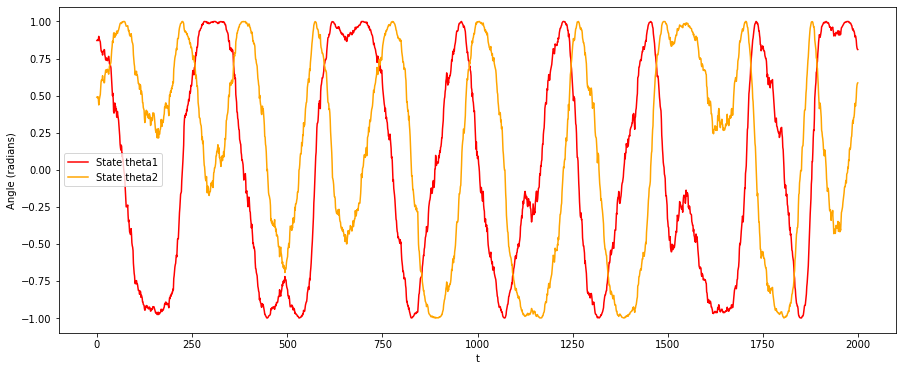

In [11]:
plt.figure(figsize=(15, 6))
# plt.plot(observations[:, 0, 0], label="Observation theta1", color='cornflowerblue')
# plt.plot(observations[:, 0, 1], label="Observation theta2", color='green')
plt.plot(sin_states[:2000, 0, 1], label="State theta1", color='red')
plt.plot(cos_states[:2000, 0, 1], label="State theta2", color='orange')
plt.xlabel('t')
plt.ylabel('Angle (radians)')
plt.legend()
plt.savefig('pendulum_angle.jpg', bbox_inches='tight')
plt.show()

### Transition function for sin/cos of angles

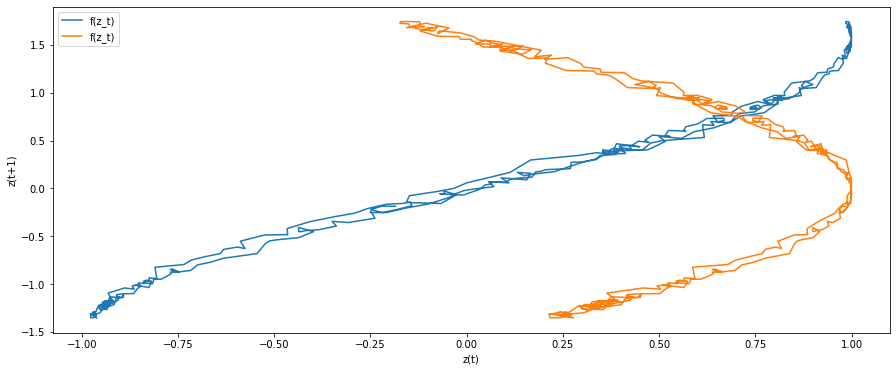

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(sin_states[:400, 0, 1], states[1:401, 0, 1], label="f(z_t)")
plt.plot(cos_states[:400, 0, 1], states[1:401, 0, 1], label="f(z_t)")
plt.xlabel('z(t)')
plt.ylabel('z(t+1)')
plt.legend()
plt.savefig('pendulum_transitions.jpg', bbox_inches='tight')
plt.show()


#### Position of the mass at the end of the double pendulum

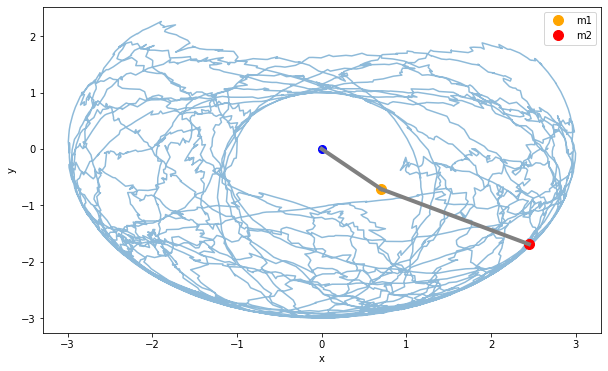

In [15]:
ox, oy = 0, 0
m1x, m1y = xs[0, 0, 0], ys[0, 0, 0]
m2x, m2y = xs[0, 0, 1], ys[0, 0, 1]

plt.figure(figsize=(10,6))

plt.plot(xs[:4000, 0, 1], ys[:4000, 0, 1], alpha=0.5)

# Pendulum
plt.plot(ox, oy, 'bo', markersize=8)
plt.plot(m1x, m1y, 'o', color='orange', markersize=10, label='m1')
plt.plot(m2x, m2y, 'o', color='red', markersize=10, label='m2')
plt.plot([ox, m1x], [oy, m1y], linewidth=4, color='gray')
plt.plot([m1x, m2x], [m1y, m2y], linewidth=4, color='gray')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# plt.savefig('pendulum_coordinates.jpg')
plt.show()

### Random Fourier Features

In [54]:
lengthscale = 1.
coef = 1. 
num_functions = 100
num_features = 4

num_steps = 1000
N = 1001

start_state = jnp.array([jnp.pi / 4, jnp.pi / 3, 0., 0.])
V0 = jnp.eye(num_features) * 2.

_, xs, _ = get_rk_state_sequence(delta_t, start_state, V0, trans_noise, obs_noise, num_steps, N)

LR_ESTIMATOR = False
NUM_TRAINING_STEPS = 2000

start_weights = jnp.ones((num_features,))
params = jnp.array([start_weights])


optimizer = optax.chain(
    optax.adam(learning_rate=0.0006),
    optax.scale(-1.0)
)

optimizer.init(params)

learned_params, training_objectives, gradients = fit(
    params=params,
    optimizer=optimizer,
    training_steps=NUM_TRAINING_STEPS,
    num_features=num_features,
    lengthscale=lengthscale,
    coef=coef,
    V0=V0, 
    start_state=start_state,
    trans_noise=trans_noise,
    obs_noise=obs_noise,
    xs=xs,
    num_steps=num_steps,
    N=N,
    lr_estimator=LR_ESTIMATOR,
)

Step 0, marginal likelihood: 0.000000, A - [1. 1. 1. 1.]


KeyboardInterrupt: 

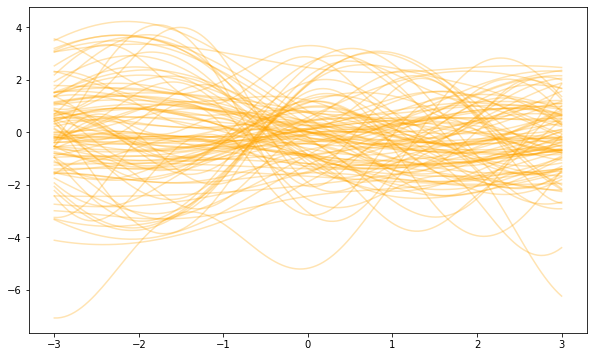

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(X, functions, color='orange', alpha=0.3)
plt.show()

In [13]:

mu0 = jnp.array([jnp.pi / 3, jnp.pi / 4, 0., 0.])
V0 = jnp.eye(4) * 0.0001

delta_t = 0.01
noise = 0.001
trans_noise = jnp.eye(4) * noise
obs_noise = jnp.eye(4) * 0.01
num_steps = 1000
N = 1

states, observations, _ = get_rk_state_sequence(
    delta_t, mu0, V0, trans_noise, obs_noise, num_steps, N
)


(1000, 1, 4)


In [92]:
mu = jnp.zeros((num_features,))
V = jnp.eye(num_features)

theta2_states = states[:, 0, 1][:, jnp.newaxis]


post_mean, post_var = get_rff_posterior(theta2_states[:-1], theta2_states[1:], num_features, lengthscale, coef, noise, mu, V)
functions = get_rff_functions(post_mean, post_var, num_functions, theta2_states[:-1], num_features, lengthscale, coef)

False
[[nan  0.  0.  0.]
 [nan nan  0.  0.]
 [nan nan nan  0.]
 [nan nan nan nan]]


In [1]:
print(post_mean)
plt.figure(figsize=(10, 6))
plt.plot(list(range(num_steps - 1)), functions[:, 0], color='orange', alpha=0.3)
plt.show()

NameError: name 'post_mean' is not defined